# Predicting likelihood of job automation

### Libraries and functions

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import (RBF,RationalQuadratic)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Assign classifications

def prob_classification(x):
    if x < 0.3:
        return "3) Low"
    elif x < 0.6:
        return "2) Medium"
    else:
        return "1) High"

### Read data

In [3]:
ML_data_2010 = pd.read_csv("ML_data_2010.csv") 
ML_data_2018 = pd.read_csv("ML_data_2018.csv")
ML_data_2010['year'] = 2010
ML_data_2018['year'] = 2018
print(ML_data_2010.shape)
print(ML_data_2018.shape)

(716, 14)
(774, 15)


In [4]:
jobs_concat = pd.concat([ML_data_2010,ML_data_2018], axis=0, ignore_index=True, sort=False)
jobs_concat.tail()

,OCC_CODE,OCC_TITLE,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML,year,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities
1485,53-7072,NaN,0.00,3.00,3.13,2.12,1.88,2.13,2.38,2.39,3.00,NaN,NaN,2018,2.877568,2.098889,2.890,2.522500
1486,53-7073,NaN,0.06,2.88,3.00,2.12,1.00,1.75,1.25,2.97,3.23,NaN,NaN,2018,2.677351,2.361111,2.788,1.957500
1487,53-7081,NaN,0.00,2.25,2.88,2.25,2.12,2.00,2.12,2.45,2.51,NaN,NaN,2018,2.401243,1.986667,2.614,2.490833
1488,53-7111,NaN,0.06,1.63,3.00,2.12,1.25,1.38,1.25,3.68,4.35,NaN,NaN,2018,2.122324,1.711111,2.740,1.930833
1489,53-7121,NaN,0.11,3.12,3.12,2.12,2.12,2.12,2.12,3.11,3.60,NaN,NaN,2018,2.848649,2.708889,3.111,2.780833


### EDA

In [5]:
jobs_concat[jobs_concat.year == 2010].describe()

,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML,year,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,68.000000,693.000000,716.0,0.0,0.0,0.0,0.0
mean,0.547839,2.736508,2.226033,2.987409,2.517483,2.742966,2.712802,2.841640,2.124754,0.573529,0.538476,2010.0,NaN,NaN,NaN,NaN
std,0.963295,0.662948,1.144053,0.649236,0.685865,0.778983,0.696622,1.177327,0.837110,0.498241,0.368785,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500000,0.000000,0.330000,0.830000,0.000000,0.880000,0.270000,1.000000,0.000000,0.002800,2010.0,NaN,NaN,NaN,NaN
25%,0.050000,2.380000,1.500000,2.500000,2.000000,2.130000,2.120000,2.017500,1.467500,0.000000,0.110000,2010.0,NaN,NaN,NaN,NaN
50%,0.210000,2.750000,2.620000,2.880000,2.500000,2.750000,2.620000,2.540000,1.895000,1.000000,0.640000,2010.0,NaN,NaN,NaN,NaN
75%,0.561250,3.130000,3.120000,3.380000,3.000000,3.298750,3.250000,3.420000,2.622500,1.000000,0.890000,2010.0,NaN,NaN,NaN,NaN
max,6.520000,5.120000,5.250000,5.880000,5.000000,5.500000,5.000000,6.590000,4.900000,1.000000,0.990000,2010.0,NaN,NaN,NaN,NaN


In [6]:
jobs_concat[jobs_concat.year == 2018].describe()

,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML,year,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,0.0,0.0,774.0,774.000000,774.000000,774.000000,774.000000
mean,0.620393,2.564126,2.144432,3.045887,2.500646,2.792373,2.707839,2.927762,2.048272,NaN,NaN,2018.0,2.673901,1.259155,1.751971,2.009712
std,0.990782,0.816929,1.179875,0.682653,0.680521,0.767115,0.694943,1.206869,0.840668,NaN,NaN,0.0,0.363418,0.889320,0.995371,0.428704
min,0.000000,0.000000,0.000000,0.330000,0.830000,0.620000,0.880000,0.270000,1.000000,NaN,NaN,2018.0,1.270865,0.000000,0.012000,1.011667
25%,0.090000,2.000000,1.227500,2.620000,2.000000,2.120000,2.120000,2.076250,1.352500,NaN,NaN,2018.0,2.420743,0.266481,0.819750,1.696875
50%,0.280000,2.750000,2.500000,3.000000,2.500000,2.880000,2.750000,2.652500,1.815000,NaN,NaN,2018.0,2.692378,1.388889,1.889000,1.957500
75%,0.668750,3.120000,3.120000,3.500000,3.000000,3.380000,3.130000,3.415000,2.620000,NaN,NaN,2018.0,2.929899,1.984167,2.625750,2.301667
max,6.510000,5.120000,6.380000,5.880000,5.000000,5.500000,4.620000,6.840000,4.550000,NaN,NaN,2018.0,3.634649,4.333333,3.911000,3.949167


In [7]:
skills = ['fine_arts','finger_dexterity','manual_dexterity','social_perceptiveness',
          'Negotiation','Originality','Persuasion','assisting_and_caring','cramped_work_space']
jobs_concat.groupby(['year']).mean()

,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities
year,,,,,,,,,,,,,,,
2010,0.547839,2.736508,2.226033,2.987409,2.517483,2.742966,2.712802,2.841640,2.124754,0.573529,0.538476,NaN,NaN,NaN,NaN
2018,0.620393,2.564126,2.144432,3.045887,2.500646,2.792373,2.707839,2.927762,2.048272,NaN,NaN,2.673901,1.259155,1.751971,2.009712


In [8]:
occ_tracking = jobs_concat[['OCC_CODE','year']].groupby(['OCC_CODE']).sum()
occ_tracking['job_span'] = ['2018 only' if a==2018 else '2010 only' if a==2010 else 'Both' for a in occ_tracking.year]
occ_tracking.drop(['year'], axis=1, inplace=True)
jobs_concat = jobs_concat.merge(occ_tracking, on = 'OCC_CODE')
jobs_concat

,OCC_CODE,OCC_TITLE,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML,year,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities,job_span
0,11-1011,Chief Executives,0.290,2.130,0.000,4.380,4.500,4.500,5.000,2.420,1.470,0.0,0.015,2010,NaN,NaN,NaN,NaN,Both
1,11-1011,NaN,0.915,2.000,0.000,3.935,3.935,4.125,4.440,2.275,1.415,NaN,NaN,2018,3.242865,0.013889,0.4560,1.837083,Both
2,11-1021,General and Operations Managers,0.060,2.750,2.250,3.620,3.500,3.250,3.500,3.600,1.320,NaN,0.160,2010,NaN,NaN,NaN,NaN,Both
3,11-1021,NaN,0.470,1.380,0.750,4.000,3.620,3.380,3.500,2.950,1.530,NaN,NaN,2018,3.026486,1.026667,1.1370,1.928333,Both
4,11-2011,Advertising and Promotions Managers,3.510,1.750,0.620,3.750,3.750,3.750,3.620,1.910,1.530,NaN,0.039,2010,NaN,NaN,NaN,NaN,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,45-2091,NaN,0.480,2.880,3.000,2.120,1.380,1.380,1.750,2.820,1.350,NaN,NaN,2018,2.259946,2.040000,3.0270,2.604167,2018 only
1486,45-2092,NaN,0.110,2.755,3.125,2.250,1.880,1.685,2.125,1.530,1.555,NaN,NaN,2018,1.918946,2.507222,2.6585,2.125417,2018 only
1487,45-2093,NaN,0.330,3.000,3.120,2.120,2.000,2.250,2.000,2.900,1.690,NaN,NaN,2018,2.640216,2.346667,2.7870,2.302500,2018 only
1488,45-3021,NaN,0.000,3.000,3.120,1.880,1.620,2.250,1.620,0.730,2.680,NaN,NaN,2018,2.324919,2.332222,2.5880,2.374167,2018 only


In [9]:
jobs_concat.groupby(['year','job_span']).mean()

fine_arts  finger_dexterity  manual_dexterity  \
year job_span                                                   
2010 Both        0.547839          2.736508          2.226033   
2018 2018 only   0.936924          1.837883          1.275188   
     Both        0.588920          2.636337          2.230863   

                social_perceptiveness  Negotiation  Originality  Persuasion  \
year job_span                                                                 
2010 Both                    2.987409     2.517483     2.742966    2.712802   
2018 2018 only               3.553705     2.773819     3.259821    3.018062   
     Both                    2.995394     2.473484     2.745894    2.676993   

                assisting_and_caring  cramped_work_space  label_ML  \
year job_span                                                        
2010 Both                   2.841640            2.124754  0.573529   
2018 2018 only              3.653176            1.529679       NaN   
     Both                   2.855633            2.099836       NaN   

                probability_ML  cognitive_abilities  physical_abilities  \
year job_span                                                             
2010 Both             0.538476                  NaN                 NaN   
2018 2018 only             NaN             2.825477            0.717723   
     Both                  NaN             2.658829            1.312990   

                psychomotor_abilities  sensory_abilities  
year job_span                                             
2010 Both                         NaN                NaN  
2018 2018 only               0.953845           1.793726  
     Both                    1.831330           2.031187

In [10]:
jobs_concat[jobs_concat.job_span == '2018 only']

,OCC_CODE,OCC_TITLE,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML,year,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities,job_span
1420,11-9039,NaN,1.02,2.060,1.375,3.75,3.50,3.685,3.685,3.32,1.325,NaN,NaN,2018,2.910649,1.278333,1.0050,1.750000,2018 only
1421,11-9061,NaN,0.27,2.380,1.880,3.62,3.38,2.620,3.620,5.45,1.210,NaN,NaN,2018,2.884973,0.985556,1.4640,2.186667,2018 only
1422,13-1071,NaN,0.02,1.380,0.500,3.88,3.00,3.120,3.000,3.66,1.140,NaN,NaN,2018,2.489892,0.166667,0.3140,1.396667,2018 only
1423,13-1075,NaN,0.55,0.000,0.000,3.88,4.25,3.750,4.250,2.90,1.300,NaN,NaN,2018,2.831459,0.180000,0.1120,1.551667,2018 only
1424,13-1131,NaN,0.66,2.250,0.120,4.00,3.62,3.500,4.380,2.84,1.190,NaN,NaN,2018,2.678973,0.027778,0.5360,1.678333,2018 only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,45-2091,NaN,0.48,2.880,3.000,2.12,1.38,1.380,1.750,2.82,1.350,NaN,NaN,2018,2.259946,2.040000,3.0270,2.604167,2018 only
1486,45-2092,NaN,0.11,2.755,3.125,2.25,1.88,1.685,2.125,1.53,1.555,NaN,NaN,2018,1.918946,2.507222,2.6585,2.125417,2018 only
1487,45-2093,NaN,0.33,3.000,3.120,2.12,2.00,2.250,2.000,2.90,1.690,NaN,NaN,2018,2.640216,2.346667,2.7870,2.302500,2018 only
1488,45-3021,NaN,0.00,3.000,3.120,1.88,1.62,2.250,1.620,0.73,2.680,NaN,NaN,2018,2.324919,2.332222,2.5880,2.374167,2018 only


In [11]:
#ML_data_2010.columns = [str(col) + '_2010' for col in ML_data_2010.columns]
#ML_data_2018.columns = [str(col) + '_2018' for col in ML_data_2018.columns]
#jobs_10_18 = ML_data_2010.merge(ML_data_2018, left_on = 'OCC_CODE_2010', right_on = 'OCC_CODE_2018', how='outer')

### Modelling

In [12]:
# Filter 2010 data for ~70 hand-labelled careers
# Create training and label sets

hand_labels_train = jobs_concat[jobs_concat.label_ML >=0]
features = ['fine_arts','finger_dexterity','manual_dexterity','social_perceptiveness','Negotiation','Originality','Persuasion','assisting_and_caring','cramped_work_space']
X_train = hand_labels_train[features]
y_train = hand_labels_train[['label_ML']]

In [13]:
# Filter 2010 data for ~70 hand-labelled careers
# Create training and label sets

#ML_train_2010 = ML_data_2010[ML_data_2010.label_ML >=0]
#features = ['fine_arts','finger_dexterity','manual_dexterity','social_perceptiveness','Negotiation','Originality','Persuasion','assisting_and_caring','cramped_work_space']
#X_train = ML_train_2010.filter(features)
#y_train = ML_train_2010.filter(['label_ML'])

In [14]:
# Train model on hand labels

#kernel = 1.0 * RBF(1.0)
kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)
gpc.score(X_train, y_train)

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9558823529411765

### Run model across occupations

In [15]:
X_all = jobs_concat[features]
GP_pred = pd.DataFrame(gpc.predict_proba(X_all))
jobs_output = pd.concat([jobs_concat,GP_pred],axis=1,ignore_index= True)
jobs_output.columns = jobs_concat.columns.tolist() + ['GP_pred_0','GP_pred_1']

In [16]:
jobs_output.head(100)

,OCC_CODE,OCC_TITLE,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,...,label_ML,probability_ML,year,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities,job_span,GP_pred_0,GP_pred_1
0,11-1011,Chief Executives,0.290000,2.130000,0.000000,4.380000,4.500000,4.500000,5.000000,2.420000,...,0.0,0.015,2010,NaN,NaN,NaN,NaN,Both,0.955642,0.044358
1,11-1011,NaN,0.915000,2.000000,0.000000,3.935000,3.935000,4.125000,4.440000,2.275000,...,NaN,NaN,2018,3.242865,0.013889,0.456000,1.837083,Both,0.926849,0.073151
2,11-1021,General and Operations Managers,0.060000,2.750000,2.250000,3.620000,3.500000,3.250000,3.500000,3.600000,...,NaN,0.160,2010,NaN,NaN,NaN,NaN,Both,0.841758,0.158242
3,11-1021,NaN,0.470000,1.380000,0.750000,4.000000,3.620000,3.380000,3.500000,2.950000,...,NaN,NaN,2018,3.026486,1.026667,1.137000,1.928333,Both,0.859625,0.140375
4,11-2011,Advertising and Promotions Managers,3.510000,1.750000,0.620000,3.750000,3.750000,3.750000,3.620000,1.910000,...,NaN,0.039,2010,NaN,NaN,NaN,NaN,Both,0.869040,0.130960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13-1199,"Business Operations Specialists, All Other*",0.166667,2.460000,0.913333,3.166667,3.126667,3.333333,3.333333,1.986667,...,NaN,0.230,2010,NaN,NaN,NaN,NaN,Both,0.445147,0.554853
96,13-1199,NaN,0.476667,1.853333,0.561667,3.188333,3.060000,3.293333,3.270000,2.150000,...,NaN,NaN,2018,2.848333,0.351481,0.612833,1.810556,Both,0.489364,0.510636
97,13-2011,Accountants and Auditors,0.225000,2.370000,0.625000,3.125000,3.065000,2.870000,3.185000,1.675000,...,1.0,0.940,2010,NaN,NaN,NaN,NaN,Both,0.158051,0.841949
98,13-2011,NaN,0.095000,1.435000,0.190000,3.125000,3.065000,3.190000,3.310000,2.485000,...,NaN,NaN,2018,2.689757,0.083333,0.275000,1.582500,Both,0.383855,0.616145


In [17]:
#X_all = ML_data_2010.filter(features)
#GP_est = pd.DataFrame(gpc.predict_proba(X_all))
#ML_output = pd.concat([ML_data_2010,GP_est],axis=1,ignore_index= True)

### Results on 2010 dataset

In [18]:
jobs_output['prob_class_old'] = jobs_output.probability_ML.apply(prob_classification)
jobs_output['prob_class_new'] = jobs_output.GP_pred_1.apply(prob_classification)
jobs_output.groupby(['prob_class_old','prob_class_new']).size()

prob_class_old  prob_class_new
1) High         1) High           685
                2) Medium         207
                3) Low            275
2) Medium       1) High            31
                2) Medium          43
                3) Low             16
3) Low          1) High             7
                2) Medium          41
                3) Low            185
dtype: int64

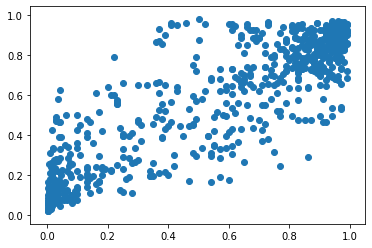

In [19]:
jobs_output_2010 = jobs_output[jobs_output.year == 2010]
plt.scatter(jobs_output_2010['probability_ML'], jobs_output_2010['GP_pred_1'])

# Shows my modelling is not perfectly aligned with researtch paper - but generally matches category

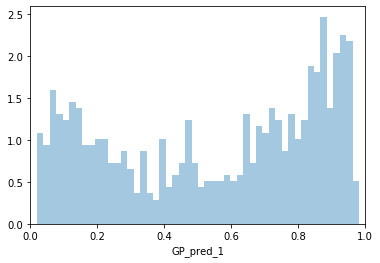

In [20]:
# 2010 distribution
ax = sns.distplot(jobs_output_2010.GP_pred_1, bins=50)
plt.xlim(0, 1)
ax.get_lines()[0].remove()

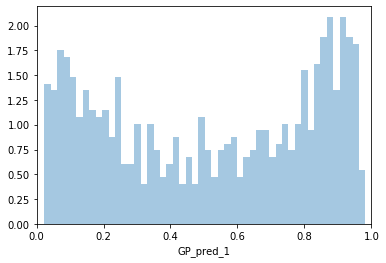

In [22]:
# 2018 distribution
jobs_output_2018 = jobs_output[jobs_output.year == 2018]
ax = sns.distplot(jobs_output_2018.GP_pred_1, bins=50)
plt.xlim(0, 1)
ax.get_lines()[0].remove()

## Output data

In [ ]:
#ML_output_2018.to_csv('ML_output_2018.csv')